In [1]:
#from supportFunctions import *
import cPickle as pickle
from __future__ import division
import numpy as np
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd 

import scipy.cluster.hierarchy as hcluster
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import cross_val_score


In [2]:
def extractFeatures(imageDict, dist = 5):
    n = imageDict['numPointsInBox']
    y = np.zeros(n)
    
    v1,v2,h1,h2 = imageDict['boxEdges']
    
    img = imageDict['image1bit']
    featuresList = []
    
    fingerSet = imageDict['allFingerPoints']

    c = 0 
    for i in range(h1,h2):
        for j in range(v1,v2):
            x_matrix  = img[i-dist-1:i+dist , j-dist-1: j+dist]
            xVec = x_matrix.ravel()
            featuresList.append(xVec)
            
            if max(np.sum([i , j] == fingerSet, axis = 1 )) == 2:
                y[c] = 1
            
            c = c + 1

    X = np.vstack((featuresList))
    return(X,y)
    

In [3]:
def extractExamplesFromList(imageList, dist = 5):
    allFeaturesList = []
    allTargetList = []

    for i, imageDict in enumerate(imageList):
        features, target = extractFeatures(imageDict, dist = dist)
        allFeaturesList.append(features)
        allTargetList.append(target)

    x = np.vstack((allFeaturesList))
    y = np.hstack((allTargetList))
    
    return x, y

In [4]:
def Reshape_to_yHatMatrix(testingExamples, yHat):
    number_of_images = len(testingExamples)
    
    image_sizes = []
    result = []
    c = 0 
    for i in range(number_of_images):
        dummy_idx = (testingExamples[i]['boxHeight'],testingExamples[i]['boxWidth'])
        image_sizes.append(dummy_idx)
        
        test_im = yHat[c:(c + dummy_idx[0]*dummy_idx[1])] 
        c = c + (dummy_idx[0] * dummy_idx[1])
        
        test_im_matrix = test_im.reshape((dummy_idx[0], dummy_idx[1]))
        result.append(test_im_matrix)
    
    return(result)

In [5]:
def remove_small_clusters(clusters, min_finger_pixel):
    unique = set(clusters)
    for c in unique:
        if sum(clusters == c) < min_finger_pixel:
            clusters = np.delete(clusters, np.where(clusters == c))
    return(clusters)

In [6]:
class clsf_Performance(object):
    """The performance of a classifier can be evaluated in different manners.

    Attributes:
        y_hat: clf output
        y_test: true values
    """

    def __init__(self, y_hat, y_test):
        
        self.y_hat = y_hat
        self.y_test = y_test

    def print_confusion_matrix(self, is_normalized = True):
        """Plots the confusion matrix."""
        if is_normalized == True : 
            normalized_confusion_matrix = confusion_matrix(self.y_test, self.y_hat)/confusion_matrix(self.y_test, self.y_hat).sum()
            df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
            plt.show()
        else:
            df_confusion = pd.DataFrame(confusion_matrix(self.y_test, self.y_hat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion, annot = True, fmt='.4g')
            plt.show()
    
    
    def Accuracy(self, normalize = True):
        # Accuracy = TP + TN / (TP + TN + FP + FN)
        return(accuracy_score(self.y_test, self.y_hat, normalize = normalize))
        
    def Recall(self):
        # Precision = TP / (TP + FP)
        return(recall_score(self.y_test, self.y_hat))
    
    def Precision(self):
        # Recall = TP / (TP + FN)
        return(precision_score(self.y_test, self.y_hat))
    
    def F1_score(self):
        # F1 = 2 * Precision * Recall / (Precision + Recall)
        return(f1_score(self.y_test, self.y_hat))
        
    def print_ROC(self, label = None):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat )
        plt.plot(fpr, tpr, label = label )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
  
    def AUC(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat)
        return(auc(fpr, tpr))
    

In [7]:
pickleFileName = 'fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

In [8]:
#Constructing Traning Data Set:
trainingExampleIndices = np.arange(0,45)
trainingExamples = [data[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, dist = 4)

#Constructing Test Data Set:
testingExampleIndices = range(45,54)
testingExamples = [data[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, dist = 4)


In [9]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
clf = clf.fit(trainX, trainY)
yHat = clf.predict(testX)

In [10]:
clf.score(testX, testY)

0.9608564297911467

## Plot Fingers Last Version

In [11]:
def plot_fingers_estimates_and_actuals_YGM(testingExampleIndices,yHat, testY, data):
    """
    For given yHat(estimated), testY(actual), and test examples,
    it visualizes these in subplots.
    
    yHat and testY should be vectors 
    
    """
    fig = plt.figure(0, (len(testingExampleIndices) + 12, len(testingExampleIndices) + 8))
    Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)
    Y_test = Reshape_to_yHatMatrix(testingExamples, testY)
    for i in range(len(testingExampleIndices)):
        
        fig.add_subplot(1,len(testingExampleIndices),i+1)
        imageDict = data[testingExampleIndices[i]]
        
        im = imageDict['croppedImage']
        grayim = np.zeros((im.shape[0], im.shape[1], 3))
        grayim[:,:,0] = 1./255*im
        grayim[:,:,1] = 1./255*im
        grayim[:,:,2] = 1./255*im
        
        grayim2 = grayim.copy()

        #Emphasizing test and estimation comparison through pixel coloring
        grayim[:,:,0][Y_test[i]==1] = 1
        grayim[:,:,1][Y_test[i]==1] = 0
        grayim[:,:,2][Y_test[i]==1] = 0
        
        grayim2[:,:,0][Y_hat[i]==1] = 0
        grayim2[:,:,1][Y_hat[i]==1] = 0
        grayim2[:,:,2][Y_hat[i]==1] = 1
        
        plt.imshow(grayim2, interpolation = 'none')
        plt.imshow(grayim, interpolation = 'none', alpha = 0.3)
        plt.tick_params(axis='both', labelsize = 12)
    plt.show()

## Max_depth hyperparameter tuning

In [ ]:
def max_depth_tuning(max_depth_list, trainX, trainY, testX):
    #max_depth_tuning
    tree_score_list = []
    for item in max_depth_list:
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        clf = clf.fit(trainX, trainY)
        yHat = clf.predict(testX)
        tree_score_list.append(("max_depth = "+str(item),clf.score(testX, testY)))
    return tree_score_list

In [ ]:
max_depth_list = range(1,24)
max_depth_tuning(max_depth_list, trainX, trainY, testX)

In [ ]:
def max_depth_tuning_Recall(max_depth_list, trainX, trainY, testX):
    #max_depth_tuning
    tree_Recallscore_list = []
    for item in max_depth_list:
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        clf = clf.fit(trainX, trainY)
        yHat = clf.predict(testX)
        DT_perf = clsf_Performance(y_hat=yHat, y_test=testY)
        tree_Recallscore_list.append(("max_depth = "+str(item), "Recall: "+str(DT_perf.Recall())))
    return tree_Recallscore_list

In [ ]:
max_depth_tuning_Recall(max_depth_list, trainX, trainY, testX)

In [ ]:
max_depth_list

### Cross validation on max_depth = [8, 9, 10, 11, 12, 13]

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def cross_validation_for_Tree(allX, allY, k_fold):
    """
    allX, allY: there is no train-test split. use whole data
    k_fold: number of folds for input data
    """
    tree_cross_score_list = []
    for item in range(1,14):
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        cv_scores = cross_val_score(clf, allX, allY, cv = k_fold)
        mean = cv_scores.mean()
        std = cv_scores.std()
        print("Cross-validation scores for"+" "+"max_depth ="+" "+str(item)+" ("+str(k_fold)+"-fold):", list(cv_scores))
        tree_cross_score_list.append(("max_depth="+" "+str(item), "Mean cv_score:"+" "+str(mean),  "Std cv_score:"+" "+str(std)))
    return tree_cross_score_list

In [ ]:
trainingExampleIndices = np.arange(0,54)
trainingExamples = [data[index] for index in trainingExampleIndices]
allX, allY = extractExamplesFromList(trainingExamples, dist = 4)

cross_validation_for_Tree(allX, allY, k_fold = 3)


# Pipeline Implementation of Tree

In [12]:
# Pipeline implementation of Decision Tree on Raw Data
from sklearn.pipeline import Pipeline
from sklearn import tree


pipeRAWTree = Pipeline([ ('clf_tree', tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 10))])



trainingExampleIndices = np.arange(0,54)
trainingExamples = [data[index] for index in trainingExampleIndices]
allX, allY = extractExamplesFromList(trainingExamples, dist = 4)

Tree_cross_val_scorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(Tree_cross_val_scorelist))
print('Classification Accuracy Scores Mean:', Tree_cross_val_scorelist.mean())
print('Classification Accuracy Scores Standart Deviation:', Tree_cross_val_scorelist.std())

('Cross Validation Accuracy Scores: ', [0.9788428165269727, 0.9837905697300889, 0.9802459107189011, 0.9786196964661571, 0.9823492485506443])
('Classification Accuracy Scores Mean:', 0.9807696483985529)
('Classification Accuracy Scores Standart Deviation:', 0.0020114859115516305)


#### Recall Score Cross-Validation

In [13]:
Tree_cross_val_Recallscorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(Tree_cross_val_Recallscorelist))
print('Classification Recall Scores Mean:', Tree_cross_val_Recallscorelist.mean())
print('Classification Recall Scores Standart Deviation:', Tree_cross_val_Recallscorelist.std())

('Cross Validation Recall Scores: ', [0.7308192457737321, 0.8849154746423927, 0.8764629388816645, 0.8458035133376708, 0.8405985686402082])
('Classification Recall Scores Mean:', 0.8357199482551337)
('Classification Recall Scores Standart Deviation:', 0.05515401654356649)


#### Precision Score Cross-Validation

In [14]:
Tree_cross_val_Precisionscorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'precision')

print("Cross Validation Precision Scores: ", list(Tree_cross_val_Precisionscorelist))
print('Classification Precision Scores Mean:', Tree_cross_val_Precisionscorelist.mean())
print('Classification Precision Scores Standart Deviation:', Tree_cross_val_Precisionscorelist.std())

('Cross Validation Precision Scores: ', [0.868663594470046, 0.8390875462392109, 0.7984588026081803, 0.7992700729927007, 0.852882703777336])
('Classification Precision Scores Mean:', 0.8316725440174947)
('Classification Precision Scores Standart Deviation:', 0.02837697551003866)


#### F1 Score Cross-Validation

In [15]:
Tree_cross_val_F1scorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'f1')

print("Cross Validation F1 Scores: ", list(Tree_cross_val_F1scorelist))
print('Classification F1 Scores Mean:', Tree_cross_val_F1scorelist.mean())
print('Classification F1 Scores Standart Deviation:', Tree_cross_val_F1scorelist.std())

('Cross Validation F1 Scores: ', [0.7974504249291784, 0.8608475648323846, 0.8354037267080746, 0.8223477715003138, 0.8468350278779928])
('Classification F1 Scores Mean:', 0.8325769031695888)
('Classification F1 Scores Standart Deviation:', 0.021674962378983725)


#### AUC Score Cross-Validation

In [18]:
Tree_cross_val_AUCscorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'roc_auc')

print("Cross Validation AUC Scores: ", list(Tree_cross_val_AUCscorelist))
print('Classification AUC Scores Mean:', Tree_cross_val_AUCscorelist.mean())
print('Classification AUC Scores Standart Deviation:', Tree_cross_val_AUCscorelist.std())

('Cross Validation AUC Scores: ', [0.9825219957844861, 0.9845633333766033, 0.9860594310608705, 0.9667623533383962, 0.9851920199541898])
('Classification AUC Scores Mean:', 0.9810198267029092)
('Classification AUC Scores Standart Deviation:', 0.007223479865643301)


In [20]:
Tree_cross_val_F1weighted_scorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'f1_weighted')

print("Cross Validation F1weighted Scores: ", list(Tree_cross_val_F1weighted_scorelist))
print('F1weighted Scores Mean:', Tree_cross_val_F1weighted_scorelist.mean())
print('F1weighted Scores Standart Deviation:', Tree_cross_val_F1weighted_scorelist.std())

('Cross Validation F1weighted Scores: ', [0.9779432397803721, 0.9838973664378723, 0.9808458667116895, 0.9797839985878656, 0.9825966030369193])
('F1weighted Scores Mean:', 0.9810134149109437)
('F1weighted Scores Standart Deviation:', 0.0020875427314816044)


## Pipeline Implementation of Logistic Regression

In [23]:
# Pipeline implementation of Logistic Regression on Raw Data
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


pipeRAWLogistic = Pipeline([ ('clf_log', LogisticRegression(random_state=0))])

Logistic_cross_val_scorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(Logistic_cross_val_scorelist))
print('Classification Accuracy Scores Mean:', Logistic_cross_val_scorelist.mean())
print('Classification Accuracy Scores Standart Deviation:', Logistic_cross_val_scorelist.std())

('Cross Validation Accuracy Scores: ', [0.971753498504597, 0.9724919691319278, 0.9737842927297566, 0.9705328459067243, 0.9738562091503268])
('Classification Accuracy Scores Mean:', 0.9724837630846664)
('Classification Accuracy Scores Standart Deviation:', 0.0012581269484603203)


#### Recall Score Cross-Validation

In [ ]:
Logistic_cross_val_Recallscorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(Logistic_cross_val_Recallscorelist))
print('Classification Recall Scores Mean:', Logistic_cross_val_Recallscorelist.mean())
print('Classification Recall Scores Standart Deviation:', Logistic_cross_val_Recallscorelist.std())

#### Precision Score Cross-Validation

In [ ]:
Logistic_cross_val_Precisionscorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5, scoring = 'precision')

print("Cross Validation Precision Scores: ", list(Logistic_cross_val_Precisionscorelist))
print('Classification Precision Scores Mean:', Logistic_cross_val_Precisionscorelist.mean())
print('Classification Precision Scores Standart Deviation:', Logistic_cross_val_Precisionscorelist.std())

#### F1 Score Cross-Validation

In [ ]:
Logistic_cross_val_F1scorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5, scoring = 'f1')

print("Cross Validation F1 Scores: ", list(Logistic_cross_val_F1scorelist))
print('Classification F1 Scores Mean:', Logistic_cross_val_F1scorelist.mean())
print('Classification F1 Scores Standart Deviation:', Logistic_cross_val_F1scorelist.std())

#### AUC Score Cross-Validation

In [ ]:
Logistic_cross_val_AUCscorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5, scoring = 'roc_auc')

print("Cross Validation AUC Scores: ", list(Logistic_cross_val_AUCscorelist))
print('Classification AUC Scores Mean:', Logistic_cross_val_AUCscorelist.mean())
print('Classification AUC Scores Standart Deviation:', Logistic_cross_val_AUCscorelist.std())

## Pipeline Implementation of Random Forest

In [24]:
# Pipeline implementation of Random Forest on Raw Data
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


pipeRAWRandomForest = Pipeline([ ('classifier_RF', RandomForestClassifier(n_estimators=10, criterion='entropy', random_state= 0))])

RF_cross_val_scorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(RF_cross_val_scorelist))
print('Classification Accuracy Scores Mean:', RF_cross_val_scorelist.mean())
print('Classification Accuracy Scores Standart Deviation:', RF_cross_val_scorelist.std())

('Cross Validation Accuracy Scores: ', [0.9836797991359894, 0.985636746298416, 0.9832736402909574, 0.9803552306044828, 0.9852664229533621])
('Classification Accuracy Scores Mean:', 0.9836423678566415)
('Classification Accuracy Scores Standart Deviation:', 0.0018739120982104432)


#### Recall Score Cross-Validation

In [ ]:
RF_cross_val_Recallscorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(RF_cross_val_Recallscorelist))
print('Classification Recall Scores Mean:', RF_cross_val_Recallscorelist.mean())
print('Classification Recall Scores Standart Deviation:', RF_cross_val_Recallscorelist.std())

#### Precision Score Cross-Validation

In [ ]:
RF_cross_val_Precisionscorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5, scoring = 'precision')

print("Cross Validation Precision Scores: ", list(RF_cross_val_Precisionscorelist))
print('Classification Precision Scores Mean:', RF_cross_val_Precisionscorelist.mean())
print('Classification Precision Scores Standart Deviation:', RF_cross_val_Precisionscorelist.std())

#### F1 Score Cross-Validaiton

In [ ]:
RF_cross_val_F1scorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5, scoring = 'f1')

print("Cross Validation F1 Scores: ", list(RF_cross_val_F1scorelist))
print('Classification F1 Scores Mean:', RF_cross_val_F1scorelist.mean())
print('Classification F1 Scores Standart Deviation:', RF_cross_val_F1scorelist.std())

#### AUC Score Cross-Validation

In [ ]:
RF_cross_val_AUCscorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5, scoring = 'roc_auc')

print("Cross Validation AUC Scores: ", list(RF_cross_val_AUCscorelist))
print('Classification AUC Scores Mean:', RF_cross_val_AUCscorelist.mean())
print('Classification AUC Scores Standart Deviation:', RF_cross_val_AUCscorelist.std())

## Pipeline Implementation of MLP-Classifier

In [14]:
# Pipeline implementation of MLP-Classifier on Raw Data
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier


pipeRAW_mlp = Pipeline([ ('mlp',MLPClassifier(hidden_layer_sizes=(54, 27, 3)))])



mlp_cross_val_scorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(mlp_cross_val_scorelist))
print('Accuracy Scores Mean:', mlp_cross_val_scorelist.mean())
print('Accuracy Scores Standart Deviation :', mlp_cross_val_scorelist.std())

('Cross Validation Accuracy Scores: ', [0.9822397814126943, 0.9864859875198464, 0.9854890521729498, 0.981721502160186, 0.9824969535836934])
('Classification Accuracy Scores Mean:', 0.9836866553698741)
('Classification Accuracy Scores Standart Deviation :', 0.0019212265065400266)


#### Recall Score Cross-Validation

In [15]:
mlp_cross_val_Recallscorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(mlp_cross_val_Recallscorelist))
print('Recall Scores Mean:', mlp_cross_val_Recallscorelist.mean())
print('Recall Scores Standart Deviation :', mlp_cross_val_Recallscorelist.std())

('Cross Validation Recall Scores: ', [0.7126137841352406, 0.8673602080624188, 0.8953185955786735, 0.0, 0.9186727391021471])
('Classification Recall Scores Mean:', 0.678793065375696)
('Classification Recall Scores Standart Deviation :', 0.3469544630113209)


#### Precision Score Cross-Validation

In [16]:
mlp_cross_val_Precisionscorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5, scoring = 'precision')

print("Cross Validation Precision Scores: ", list(mlp_cross_val_Precisionscorelist))
print('Precision Scores Mean:', mlp_cross_val_Precisionscorelist.mean())
print('Precision Scores Standart Deviation :', mlp_cross_val_Precisionscorelist.std())

('Cross Validation Precision Scores: ', [0.8938428874734607, 0.9159604519774012, 0.9096638655462185, 0.8131661442006269, 0.839536302623551])
('Classification Precision Scores Mean:', 0.8744339303642515)
('Classification Precision Scores Standart Deviation :', 0.04077718477188008)


#### F1 Score Cross-Validation

In [17]:
mlp_cross_val_F1scorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5, scoring = 'f1')

print("Cross Validation F1 Scores: ", list(mlp_cross_val_F1scorelist))
print('F1 Scores Mean:', mlp_cross_val_F1scorelist.mean())
print('F1 Scores Standart Deviation :', mlp_cross_val_F1scorelist.std())

C:\Users\eerca\Anaconda3_2\envs\py27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


('Cross Validation F1 Scores: ', [0.8608870967741936, 0.0, 0.844792375765827, 0.8321214037306355, 0.8620796050601667])
('Classification F1 Scores Mean:', 0.6799760962661645)
('Classification F1 Scores Standart Deviation :', 0.34016777333687703)


#### AUC Score Cross-Validation

In [18]:
mlp_cross_val_AUCscorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5, scoring = 'roc_auc')

print("Cross Validation AUC Scores: ", list(mlp_cross_val_AUCscorelist))
print('AUC Scores Mean:', mlp_cross_val_AUCscorelist.mean())
print('AUC Scores Standart Deviation :', mlp_cross_val_AUCscorelist.std())

('Cross Validation AUC Scores: ', [0.9947620800234981, 0.9964515308791109, 0.5, 0.9924352148007568, 0.9956813645293126])
('Classification AUC Scores Mean:', 0.8958660380465358)
('Classification AUC Scores Standart Deviation :', 0.1979376133359164)


## Results

### Tree

In [19]:
yHat_Tree = pipeRAWTree.fit(trainX, trainY).predict(testX)
DT_perf = clsf_Performance(y_hat=yHat_Tree, y_test=testY)

print ('Accuracy: '+ str(DT_perf.Accuracy()))
print ('Recall: '+ str(DT_perf.Recall()))
print ('Precision: '+ str(DT_perf.Precision()))
print ('AUC: '+ str(DT_perf.AUC()))

Accuracy: 0.9785016857130348
Recall: 0.817261330761813
Precision: 0.9380188157166575
AUC: 0.9059338197271621


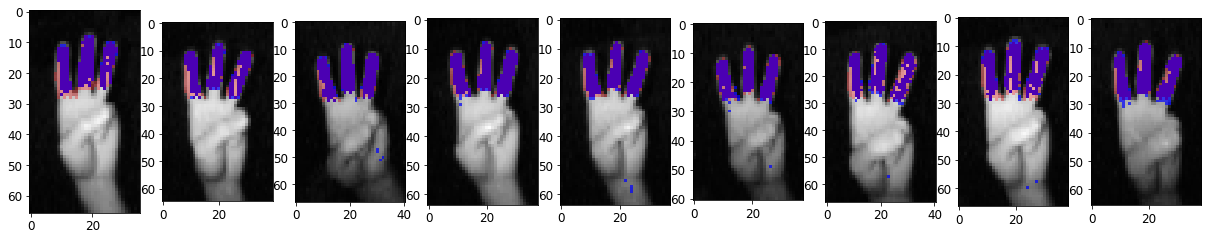

In [20]:
plot_fingers_estimates_and_actuals_YGM(testingExampleIndices, yHat_Tree, testY, data)

### Logistic

In [25]:
yHat_Log = pipeRAWLogistic.fit(trainX, trainY).predict(testX)
Log_perf = clsf_Performance(y_hat=yHat_Log, y_test=testY)

print ('Accuracy: '+ str(Log_perf.Accuracy()))
print ('Recall: '+ str(Log_perf.Recall()))
print ('Precision: '+ str(Log_perf.Precision()))
print ('AUC: '+ str(Log_perf.AUC()))

Accuracy: 0.9606375060204037
Recall: 0.6080038572806171
Precision: 0.9361544172234595
AUC: 0.8019311364418978


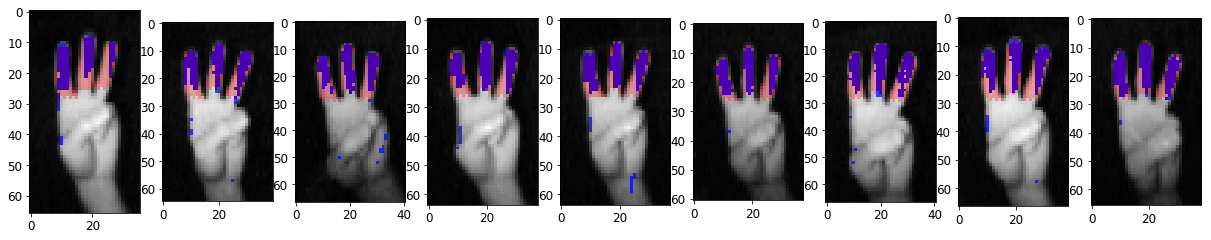

In [26]:
plot_fingers_estimates_and_actuals_YGM(testingExampleIndices, yHat_Log, testY, data)

### Random Forest

In [27]:
yHat_RF = pipeRAWRandomForest.fit(trainX, trainY).predict(testX)
RF_perf = clsf_Performance(y_hat=yHat_RF, y_test=testY)

print ('Accuracy: '+ str(RF_perf.Accuracy()))
print ('Recall: '+ str(RF_perf.Recall()))
print ('Precision: '+ str(RF_perf.Precision()))
print ('AUC: '+ str(RF_perf.AUC()))

Accuracy: 0.9802092911248304
Recall: 0.8423336547733847
Precision: 0.9332264957264957
AUC: 0.9181569550052814


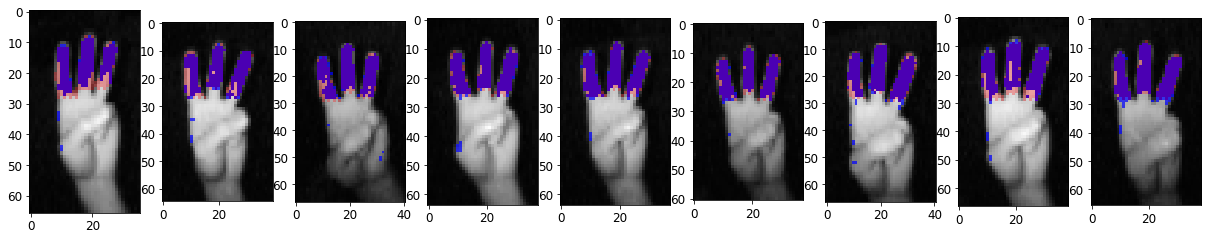

In [28]:
plot_fingers_estimates_and_actuals_YGM(testingExampleIndices, yHat_RF, testY, data)

### MLP

In [29]:
yHat_mlp = pipeRAW_mlp.fit(trainX, trainY).predict(testX)
MLP_perf = clsf_Performance(y_hat=yHat_mlp, y_test=testY)

print ('Accuracy: '+ str(MLP_perf.Accuracy()))
print ('Recall: '+ str(MLP_perf.Recall()))
print ('Precision: '+ str(MLP_perf.Precision()))
print ('AUC: '+ str(MLP_perf.AUC()))

Accuracy: 0.9808660624370594
Recall: 0.8447444551591128
Precision: 0.9384038564542047
AUC: 0.9196031449886582


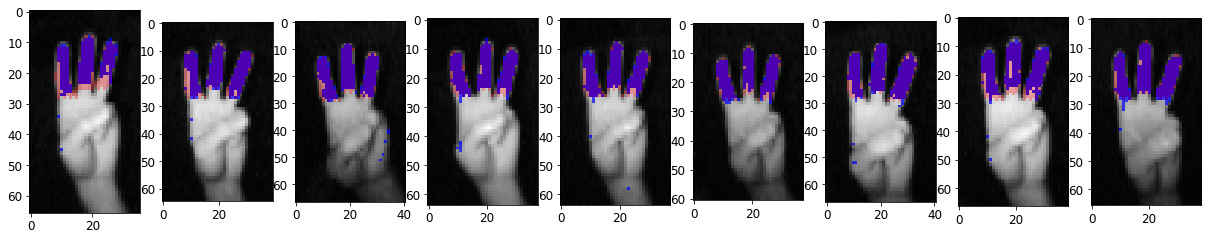

In [30]:
plot_fingers_estimates_and_actuals_YGM(testingExampleIndices, yHat_mlp, testY, data)

## Validation Curve Function

In [ ]:
from sklearn.model_selection import validation_curve

In [26]:
def plot_validation_curve(allX, allY, fold_number, param_range, scoring_metric):
    
    train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(criterion = 'entropy'), allX, allY,
                                             param_name = "max_depth", param_range = param_range, scoring = scoring_metric, cv = fold_number)
    plt.figure(figsize = (12,8))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title('Validation Curve with DecisionTree', fontsize = 16)
    plt.xlabel('max_depth', fontsize = 16)
    plt.ylabel('Score', fontsize = 16)

    lw = 2

    plt.plot(param_range, train_scores_mean, label='Training score',
                color='darkorange', lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color='darkorange', lw=lw)

    plt.plot(param_range, test_scores_mean, label='Cross-validation Recall score',
                color='navy', lw=lw)

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color='navy', lw=lw)

    plt.scatter(param_range[np.argmax(test_scores_mean)], test_scores_mean[np.argmax(test_scores_mean)], marker=(5,1,0),color='r',s=1000)

    plt.legend(loc='best', fontsize = 11)
    plt.grid()
    plt.show()
    print("Pick the parameter as : ", param_range[np.argmax(test_scores_mean)])

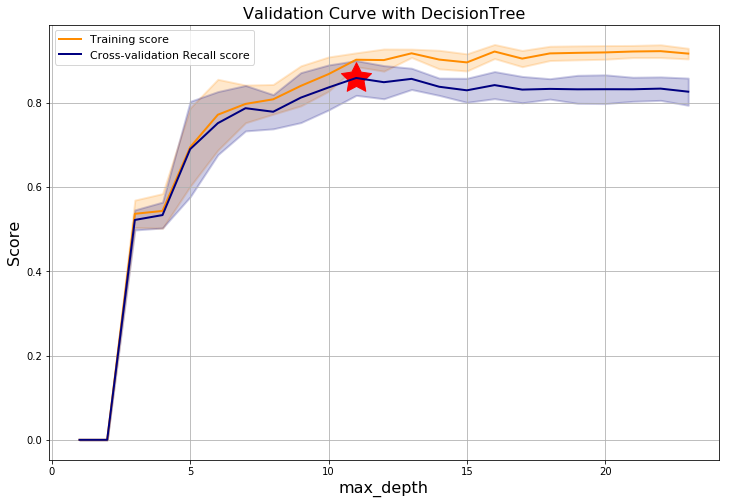

('Pick the parameter as : ', 11)


In [27]:
fold_number = 5
scoring_metric = 'recall'
plot_validation_curve(allX, allY, fold_number, param_range, scoring_metric)

## Learning Curve Function

In [ ]:
from sklearn.model_selection import learning_curve

In [29]:
def plot_learning_curve(allX, allY, train_sizes, fold_number, scoring_metric):
    train_sizes_learning_curve, train_scores_learning_curve, test_scores_learning_curve = learning_curve(tree.DecisionTreeClassifier(criterion = 'entropy'), allX, allY,
                                                                                                         train_sizes = train_sizes,scoring = scoring_metric, cv = 5 )
    plt.figure(figsize = (12,8))

    train_scores_learning_curve_mean = np.mean(train_scores_learning_curve, axis=1)
    train_scores_learning_curve_std = np.std(train_scores_learning_curve, axis=1)
    test_scores_learning_curve_mean = np.mean(test_scores_learning_curve, axis=1)
    test_scores_learning_std = np.std(test_scores_learning_curve, axis=1)

    plt.title('Learning Curve with DecisionTree', fontsize = 16)
    plt.xlabel('Training Examples', fontsize = 16)
    plt.ylabel('Score', fontsize = 16)

    lw = 2

    plt.plot(train_sizes_learning_curve, train_scores_learning_curve_mean, 'o-',
             label='Training score', color='darkorange', lw=lw)

    plt.fill_between(train_sizes_learning_curve, train_scores_learning_curve_mean - train_scores_learning_curve_std,
                    train_scores_learning_curve_mean + train_scores_learning_curve_std, alpha=0.1,
                    color='darkorange', lw=lw)

    plt.plot(train_sizes_learning_curve, test_scores_learning_curve_mean,  'o-',
             label='Cross-validation Recall score', color='navy', lw=lw)

    plt.fill_between(train_sizes_learning_curve, test_scores_learning_curve_mean - test_scores_learning_std,
                    test_scores_learning_curve_mean + test_scores_learning_std, alpha=0.2,
                    color='navy', lw=lw)



    plt.legend(loc='best', fontsize = 11)
    plt.grid()
    plt.show()

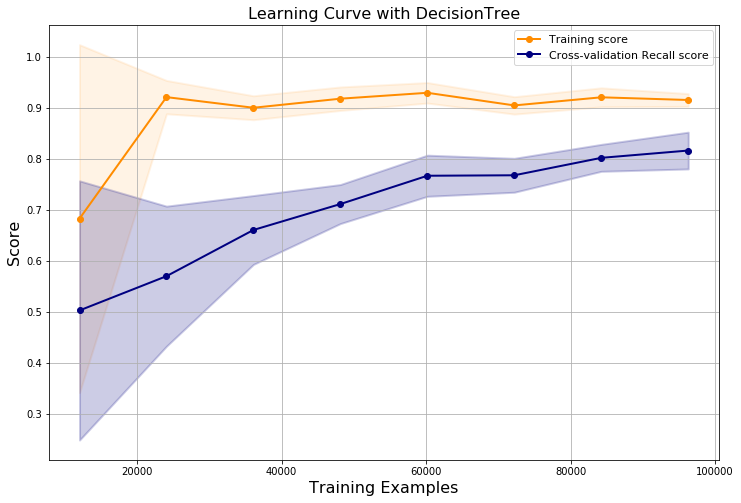

In [30]:
train_sizes = np.linspace(0, 1, 10)[1:9]
fold_number = 4
scoring_metric = 'recall'
plot_learning_curve(allX, allY, train_sizes, fold_number, scoring_metric)